# Plot Training Loss History of FSI Problem

We already saved the training loss history in the saved checkpoints.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

Import local packages


In [ ]:
from src.utils.logger import Logging
from src.utils.plot_loss import plot_loss_history
from src.utils.color import model_color

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

## Create logger


In [ ]:
TEST_DATA_PKL = "../../data/IB_PINN3.mat"
TEST_CHECKPOINT_PATH = "result/fsi"

logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

In [ ]:
RBA = ".checkpoints/fsi/2024-10-17_18-18-48-029989/model.pth"  # ".checkpoints/fsi/2024-10-16_18-05-23-054477/model.pth"
FIXED_WEIGHT = ".checkpoints/fsi/2024-10-17_17-46-43-410794/model.pth"  # ".checkpoints/fsi/2024-10-16_17-28-42-573363/model.pth"
SA = ".checkpoints/fsi/2024-10-16_18-32-58-880576/model.pth"  # ".checkpoints/fsi/2024-10-15_17-37-33-081291/model.pth"
Grad_stat = ".checkpoints/fsi/2024-10-17_17-30-15-380032/model.pth"  # ".checkpoints/fsi/2024-10-16_17-51-22-642694/model.pth"  # ".checkpoints/fsi/2024-10-15_17-37-23-782676/model.pth"

MODEL_PATH_LIST = {
    "RBA": RBA,
    "Fixed": FIXED_WEIGHT,
    "SA": SA,
    "grad_stat": Grad_stat,
}


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
}

DEVICE = "cpu"

## Plot Training Loss History

I saved the training loss in a pickle file during training so that I can plot it later as needed.


### Load Saved Model


In [6]:
all_loss_history = {}

for method, model_path in MODEL_PATH_LIST.items():
    # Load the state from the saved model
    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")

    # Extract model configuration from state
    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_history = state.get("loss_history")

    for lkey, lvalue in loss_history.items():
        logger.print(f"loss: {lkey} , final loss: {lvalue[-1]:.2e}")

    final_loss_sum = sum([l[-1] for l in loss_history.values()])
    logger.print(f"final loss sum: {final_loss_sum:.2e}")
    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(model_architecture, model_activation_name).to("cpu")

    model.load_state_dict(state["model_state_dict"])

    logger.print(f"model loaded from {model_path}")
    logger.print(f"problem: {config.get('problem')}")
    logger.print(f"dataset_path:  , {config.get('dataset_path')}")
    logger.print(f"batch size:  , {config.get('batch_size')}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")
    logger.print(f"weighting:  , {config.get('weighting')}")
    logger.print(f"solver:  , {config.get('solver')}")
    logger.print(
        f"number of iterations:  , {len(loss_history[next(iter(loss_history))])}"
    )
    all_loss_history[method] = loss_history

INFO:src.utils.logger:loss: left , final loss: 2.41e-02
INFO:src.utils.logger:loss: right , final loss: 3.44e-02
INFO:src.utils.logger:loss: bottom , final loss: 2.18e-03
INFO:src.utils.logger:loss: up , final loss: 6.46e-02
INFO:src.utils.logger:loss: fluid_points , final loss: 3.98e+00
INFO:src.utils.logger:loss: initial , final loss: 5.61e-02
INFO:src.utils.logger:loss: fluid , final loss: 1.13e-01
INFO:src.utils.logger:final loss sum: 4.27e+00
INFO:src.utils.logger:model loaded from /home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-17_18-18-48-029989/model.pth
INFO:src.utils.logger:problem: fsi
INFO:src.utils.logger:dataset_path:  , None
INFO:src.utils.logger:batch size:  , 128
INFO:src.utils.logger:network:  , [3, 400, 400, 400, 400, 5]
INFO:src.utils.logger:term loss weights :  , None
INFO:src.utils.logger:weighting:  , RBA
INFO:src.utils.logger:solver:  , xsig
INFO:src.utils.logger:number of iterations:  , 10001
INFO:src.utils.logger:loss: left , final loss: 1.50e-03


Pre-process the loss data for plotting. See the Helmholtz notebook to understand the data structure.


In [7]:
keys = all_loss_history.keys()
values = all_loss_history.values()

# Dictionary to store model and its summed loss
model_summed_loss_dict = {}

# Calculate summed loss
# Iterate over each model, e.g., tanh and sum their losses, e.g, lbcs, phy, ...
for model, loss_dict in zip(keys, values):
    total_loss = np.zeros(
        len(
            next(iter(loss_dict.values()))
        )  # Assume each loss history is of equal length
    )  # Initialize total_loss with zeros

    print(f"{model=}, #iter={len(total_loss)}")

    # Sum all losses across keys for each model
    # Exclude the physics loss for Helmholtz
    for key in loss_dict:
        if key not in ["fluid"]:
            total_loss += np.array(loss_dict[key])

    model_summed_loss_dict[model] = total_loss

# Determine the minimum length across all summed losses
min_length = min([len(x) for x in model_summed_loss_dict.values()])
# Truncate the lists in model_summed_loss_dict to the minimum length
for key in model_summed_loss_dict:
    model_summed_loss_dict[key] = model_summed_loss_dict[key][0:min_length]

print("Truncated model_summed_loss_dict:", model_summed_loss_dict.keys())
print("Truncated model_summed_loss_dict:", len(model_summed_loss_dict.get("Fixed")))

model='RBA', #iter=10001
model='Fixed', #iter=50001
model='SA', #iter=60001
model='grad_stat', #iter=60001
Truncated model_summed_loss_dict: dict_keys(['RBA', 'Fixed', 'SA', 'grad_stat'])
Truncated model_summed_loss_dict: 10001


### Plot Loss History

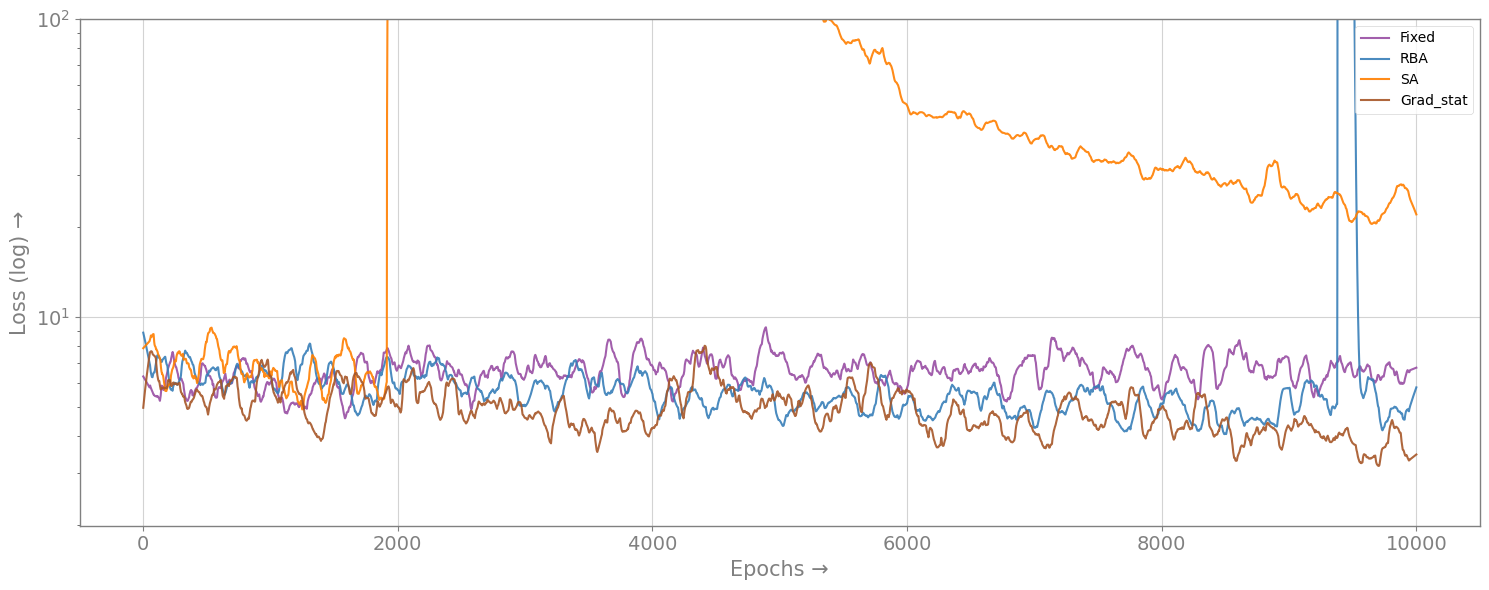

In [9]:
data_list = [
    {
        "data": model_summed_loss_dict["Fixed"],
        "color": model_color["tanh"],
        "name": "Fixed",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["RBA"],
        "color": model_color["bspline"],
        "name": "RBA",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["SA"],
        "color": model_color["param_tanh"],
        "name": "SA",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["grad_stat"],
        "color": model_color["grbf"],
        "name": "Grad_stat",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    # {
    #     "data": model_summed_loss_dict["fourier"],
    #     "color": model_color["fourier"],
    #     "name": "Fourier(A1)",
    #     "alpha": 0.1,
    #     "window": 100,
    #     "show_avg": False,
    #     "show_lower": False,
    # },
    # {
    #     "data": model_summed_loss_dict["chebyshev"],
    #     "color": model_color["chebyshev"],
    #     "name": "Chebyshev(A2)",
    #     "alpha": 0.1,
    #     "window": 100,
    #     "show_avg": False,
    #     "show_lower": False,
    # },
    # {
    #     "data": model_summed_loss_dict["jacobi"],
    #     "color": model_color["jacobi"],
    #     "name": "Jacobi(A1)",
    #     "alpha": 0.1,
    #     "window": 100,
    #     "show_avg": False,
    #     "show_lower": False,
    # },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_cavity.png"),
    y_max=100,
)